# Advance lane finding project

See detailed description in [README.md](./README.md)

## Imports and some helper function

In [1]:
#importing math and image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

#file mangement
import os
import pickle
import os.path
import glob
# Edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

def get_image_list(dir_name):
    """
    Helper function to read all images from the disk
    """
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    for file_name in file_list:
        image_list.append(mpimg.imread(file_name))
    return image_list
def test_img(image_list, funcs):
    """ 
    Helper function to display results of pipeline steps over multiple images
    """
    fig = plt.figure(figsize=(10, 15))
    num_img = len(image_list)
    for index, image in enumerate(image_list):
        vis = []
        for func in funcs:
            vis.append(func(image))
        result = np.concatenate(vis, axis=1)
        ax=fig.add_subplot(num_img,1,index+1)
        ax.imshow(result, cmap='gray')
        #ax.grid(True)
    plt.show()

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draw lines from list onto the image
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Camera Calibraion

In [4]:
def get_obj_points(cal_file_name, nx, ny):
    """
    support function to prepare object points array and
    detected corners points array
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(cal_file_name + "/*.jpg")

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints
def get_undistort_params(name):
    """
    returuns parameters that are required by cv2.undistort funciton
    the parameters are compuated and cached on disk for efficiency
    """
    chess_nx = 9
    chess_ny = 5
    if os.path.isfile(name+".p"):
        # Read in the saved objpoints and imgpoints
        dist_pickle = pickle.load( open( name+".p", "rb" ) )
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    else:
        objpoints, imgpoints = get_obj_points(name, chess_nx, chess_ny)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( name+".p", "wb" ) )
    return mtx, dist
def undistort(img, name = './camera_cal'):
    """
    short call for undistort using default calibration parameters
    """
    mtx, dist = get_undistort_params(name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    

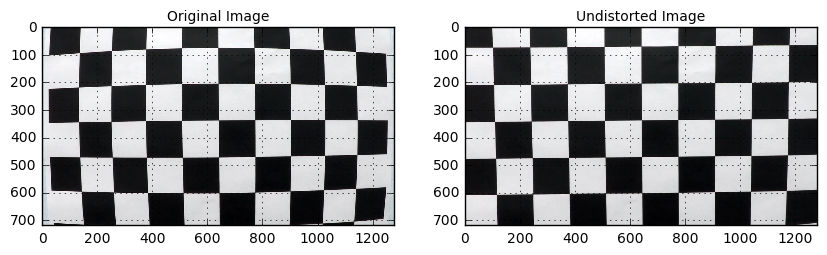

In [5]:
def test_camera_calibration():
    # Test undistortion on an image
    img = cv2.imread('camera_cal/calibration1.jpg')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax1.grid(True)
    ax2.imshow(undistort(img))
    ax2.set_title('Undistorted Image', fontsize=10)
    ax2.grid(True)
    fig.savefig("./output_images/camera_calibration.png", bbox_inches='tight')
test_camera_calibration()

## Perspective Transform

In [6]:
y_top_off = 450
x_top_off = 505
x_bot_off = -500
y_bot_off = 30
ym_per_pix = 3.0/(521.0-447.0)# meters per pixel in y dimension
xm_per_pix = 3.7/(877.0-422.0) # meters per pixel in x dimension

def tilt_up(img):
    """
    Perspective Transform of the road to the top view
    """
    img_u=img
    my,mx = img.shape[0:2]
    src_corners = np.float32([[x_top_off,         y_top_off],
                              [x_bot_off,    my - y_bot_off],
                              [mx-x_top_off,      y_top_off],
                              [mx-x_bot_off,   my-y_bot_off]])
    dst_corners = np.float32([[0,0],[0,my],[mx,0],[mx,my]])
    Minv = cv2.getPerspectiveTransform( src_corners,dst_corners)
    warped = cv2.warpPerspective(img_u, Minv, (mx,my), flags=cv2.INTER_CUBIC)
    return warped

def tilt_down(img):
    """
    Perspective Transform from top view to the road plane
    """
    img_u=img
    my,mx = img.shape[0:2]
    src_corners = np.float32([[x_top_off,         y_top_off],
                              [x_bot_off,    my - y_bot_off],
                              [mx-x_top_off,      y_top_off],
                              [mx-x_bot_off,   my-y_bot_off]])
    dst_corners = np.float32([[0,0],[0,my],[mx,0],[mx,my]])
    Minv = cv2.getPerspectiveTransform( dst_corners,src_corners)
    warped = cv2.warpPerspective(img_u, Minv, (mx,my), flags=cv2.INTER_CUBIC)
    return warped

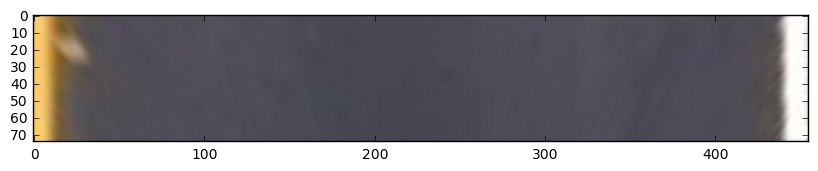

In [7]:
def test_dims(): 
    """
    test image used to identfy ym_per_pix and xm_per_pix
    """
    test_img(get_image_list("./test_images")[0:1], [
        lambda x: tilt_up(undistort(x))[447:521,422:877],
     ])
test_dims()

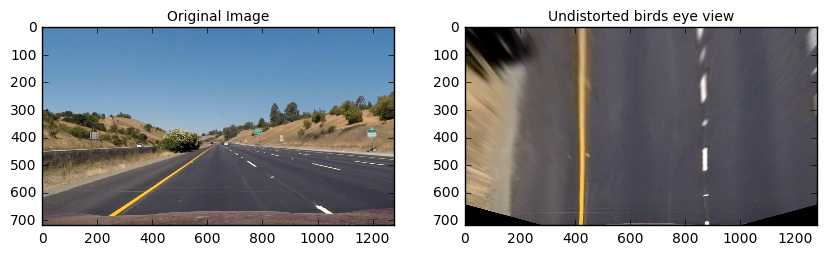

In [8]:
def test_perspective_transform_calibration():
    # Test undistortion on an image
    img = get_image_list("./test_images")[0]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(tilt_up(undistort(img)))
    ax2.set_title('Undistorted birds eye view', fontsize=10)
    fig.savefig("./output_images/birds_eye_view.png", bbox_inches='tight')
test_perspective_transform_calibration()

##  The pipeline 

In [9]:

## short calls for changing color space and selectig a specific chanels
def hls(img, c = 2):
    dec = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
    channel = dec[:,:,c]
    return channel

def hsv(img, c = 2):
    dec = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
    channel = dec[:,:,c]
    return channel

def yuv(img, c = 2):
    dec = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    s_channel = dec[:,:,c]
    return s_channel

def fimg(img):
    """ 
    function to allow concatenate single chanel image with colored image 
    """
    img3 = np.dstack((img,img,img))
    return img3


def remove_mask(img, mask):
    """ nullifying part of the image based on mask"""
    img[mask!=0] = 0
    return img

def smart_th_select(image, p = 2.7, steps_y =10, steps_x = 1):
    """
    The dynamic adaptive thresholding
    Split image on given number of parts 
    Based on values distribution in a section chose pixels that are above the mean by variance * p  """
    my,mx = image.shape[0:2]
    step_y = int(my/steps_y)
    step_x = int(my/steps_x)
    result = np.zeros_like(image)
    for line in range(0, my, step_y):
        for col in range(0, mx, step_x):
            mean_vals = cv2.meanStdDev(image[line:line + step_y,col:col + step_x]) 
            #take only upper part o of std deviation, so there is no need to tune for specific thresholds
            v_lower = np.uint8(min([[255], np.round(mean_vals[0]+mean_vals[1]*p)]))
            result[line:line + step_y,col:col + step_x]= cv2.inRange(image[line:line + step_y,col:col + step_x], np.uint8(np.array(v_lower)), np.uint8(np.array([255])))
    
    return result

def color_select(top_img, heat_map_left = None, heat_map_right = None):
    """
    Main part of the pipeline the color selection
    top_img is the bird's eye view on the road
    heat_map_left  expected position of the left line
    heat_map_right  expected position of the right line
    The detailed description is in the report
    """
    mid = int(top_img.shape[1]/2)
    if heat_map_left == None:
        heat_map_left = np.zeros(top_img.shape[0:2],np.uint8)
        heat_map_left[:,300:mid-150] = 255
    if heat_map_right == None:
        heat_map_right = np.zeros(top_img.shape[0:2],np.uint8)
        heat_map_right[:,mid+150:-300] = 255
    dark_mask = cv2.inRange(hls(top_img,1),0,40)
    #TODO add dilate to remove pixels next to dark zones (false positives)
    hsv_mask = smart_th_select(hsv(top_img,2),2.5, 5, 1)
    hsv_mask = remove_mask(hsv_mask, dark_mask)
    
    kernel = np.ones((3,3), dtype=hsv_mask.dtype)
    hsv_mask = cv2.erode(hsv_mask,kernel,10)
    
    hls_mask = smart_th_select(hls(top_img,2),2.5, 5, 1)
    hls_mask = remove_mask(hls_mask, dark_mask)
    
    kernel = np.ones((3,3), dtype=hls_mask.dtype)
    hls_mask = cv2.erode(hls_mask,kernel,10)

    #TODO combine can be done with Gaussian filter->sum->threshold better spacial filtering
    left_line_color  = (hsv_mask+hls_mask) & heat_map_left
    right_line_color = (hsv_mask+hls_mask) & heat_map_right
    return left_line_color, right_line_color

def sobel_x(gray):
    """ 
    Edge detection  Scharr (is better then Sobel) 
    dilate to make edges thicker and improve future line detection
    """
    sobelx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    kernel = np.ones((3,3), dtype=abs_sobelx.dtype)
    abs_sobelx = cv2.dilate(abs_sobelx,kernel,8)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    return scaled_sobel

def generate_inital_heat_map(top_img, rho=1,theta=np.pi/180, threshold = 10, min_line_len = 30, max_line_gap=1):
    """
    initial heat map generation based on edge detection and Hough transform to reduce the effect of outliers
    the default parameters are result of the tuning on test images
    """
    img = sobel_x(top_img)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    ysize = top_img.shape[0]
    if lines is None:
        return None
    el = extarpolate_lines(fit_line(lines),0, ysize)
    line_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    draw_lines(line_img, el, color = 255, thickness = 122)
    return line_img

def get_fit(hot_img, ploty):
    """
    hot_img is a binary image with pixel to be fitted
    ploty extrapolation range in y
    returns array of points in x 
    """
    warped_mask = np.nonzero(hot_img)
    if len(warped_mask[0])!=0 and len(warped_mask[1])!=0:
        #warped_mask = warped_mask[::-1]
        fit = np.polyfit( warped_mask[0],warped_mask[1], 2)
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        
    else:
        fitx = np.zeros_like(ploty)
    return fitx

def plot_fit(hot_left, hot_right):
    """
    hot_left is a binary image with pixel of the left line
    hot_right is a binary image with pixel of the right line
    returns  new image with a filled polygon used to indicate  the position of the lane on the road  """
    dummy = np.zeros((hot_left.shape[0], hot_left.shape[1], 1), dtype=np.uint8)
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = get_fit(hot_left, ploty)
    right_fitx = get_fit(hot_right, ploty)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(dummy, np.int_([pts]), 255) 
    return dummy

def get_curvature(img):
    """
    img is a binary image with pixels to be fitted
    returns curvature in radians and y position of the fitted second order polynomial at the bottom of the image 
    Note: ym_per_pix and xm_per_pix global variables are used
    """
    warped_mask = np.nonzero(img)
    if len(warped_mask[0])!=0 and len(warped_mask[1])!=0:
        line_params = np.polyfit( warped_mask[0]* ym_per_pix,warped_mask[1]*xm_per_pix, 2)
        y_eval = np.max(img.shape[0]) * ym_per_pix # get bottom of the screen
         # Calculate the new radii of curvature
        curverad = ((1 + (2*line_params[0]*y_eval + line_params[1])**2)**1.5) / np.absolute(2*line_params[0])
        y_pos = line_params[0]*y_eval**2 + line_params[1]*y_eval + line_params[2]
    else:
        curverad = np.infty
        y_pos = np.infty
    return curverad, y_pos

def get_new_heat_map(hot_img):
    """
    hot_img is a binary image with pixels to be fitted
    returns a new binary image where the line is to be expected in next frame
    """
    dummy = np.zeros((hot_img.shape[0], hot_img.shape[1], 1), dtype=np.uint8)
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    fitx = get_fit(hot_img, ploty)
    for y,x in zip(ploty, fitx):        
            dummy[y,np.max([0,np.min([x,hot_img.shape[1]-1])])] = 255
    kernel = np.ones((122,122), dtype=hot_img.dtype)
    dummy = cv2.dilate(dummy,kernel,1)
    return dummy

def fit_line(lines):
    """
    Fit the best line based on all available lines, 
    using least square to fit
    returns parameters of one line
    """
    x_values = []
    y_values = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            x_values.append(x1)
            x_values.append(x2)
            y_values.append([y1, 1.0])
            y_values.append([y2, 1.0])
    x_values=np.array(x_values)
    y_values=np.array(y_values)
    fit_values=np.linalg.pinv(np.array(y_values)).dot(np.array(x_values))
    slope = fit_values[0] 
    offest = fit_values[1]
    return [(slope, offest)]

def extarpolate_lines(fit, y1 ,y2):
    """   
        Given line parameters generate a line for given y1,y2 points
    """
    for a, b in fit:
        line = (int(a*y1 + b), int(y1), int(a*y2 + b), int(y2))
    return [[line]]


class Pipeline(object):
    
    """
      The algorithm container.
    Usage instantiate the class with no parameters and call process function on consecutive frames.
    For single images create the new instance for each image.
    """
    def __init__(self):
        self.heat_map_left = None
        self.heat_map_right = None
        self.final_left = None
        self.final_right = None
        
        
    def process(self, img):
        """
        definition of the processing steps
        input is a camera image
        output is the camera image augmented with lane mark up and lane properties text
        """
        top_img = tilt_up(undistort(img))
        if self.heat_map_left == None or self.heat_map_right == None:
            init_left, init_right = color_select(top_img)
            self.heat_map_left  = generate_inital_heat_map(init_left)
            self.heat_map_right = generate_inital_heat_map(init_right)
            
        final_left, final_right = color_select(top_img, self.heat_map_left, self.heat_map_right)

        left_curv, pos_l = get_curvature(final_left)
        right_curv, pos_r = get_curvature(final_right)
        
        heat_map_left =  get_new_heat_map(final_left)
        heat_map_right = get_new_heat_map(final_right)
        
        if abs(pos_r-pos_l) > 3.0 and abs(pos_r-pos_l) < 4.5  or  self.final_left is None:
            #store
            self.heat_map_left =  heat_map_left 
            self.heat_map_right = heat_map_right
            self.final_left  = final_left 
            self.final_right = final_right
        else: 
            # reset
            self.heat_map_left = None  
            self.heat_map_right = None
            final_left  = self.final_left 
            final_right = self.final_right
            left_curv, pos_l = get_curvature(final_left)
            right_curv, pos_r = get_curvature(final_right)
            heat_map_left =  get_new_heat_map(final_left)
            heat_map_right = get_new_heat_map(final_right)
        
        dummy = plot_fit(final_left, final_right)   
        final_line = np.dstack((dummy, heat_map_left, heat_map_right))
        curve_str_l = "Left   = "+ "{:.3f}".format(left_curv)
        curve_str_r = "Right  = "+ "{:.3f}".format(right_curv) 
        curve_str   = "Curve  = "+ "{:.3f}".format((right_curv+left_curv)/2.0) 
        wi_str      = "W Lane = "+ "{:.3f}".format((pos_r-pos_l)) 
        pos_str     = "Pos    = "+ "{:.3f}".format(((pos_r-pos_l)/2.0+pos_l) - img.shape[1]/2*xm_per_pix) 
        

        final = weighted_img( (img), tilt_down(final_line))
        font = cv2.FONT_HERSHEY_SIMPLEX
        final = cv2.putText(final, curve_str_l,(0,80), font, 2,(255,0,0),2,cv2.LINE_AA)
        final = cv2.putText(final, curve_str_r,(0,160), font, 2,(255,0,0),2,cv2.LINE_AA)
        final = cv2.putText(final, curve_str, (0,240), font, 2,(255,0,0),2,cv2.LINE_AA)
        final = cv2.putText(final, wi_str, (0,320), font, 2,(255,0,0),2,cv2.LINE_AA)
        final = cv2.putText(final, pos_str, (0,400), font, 2,(255,0,0),2,cv2.LINE_AA)

        return final
  

## Visualize steps in color select function

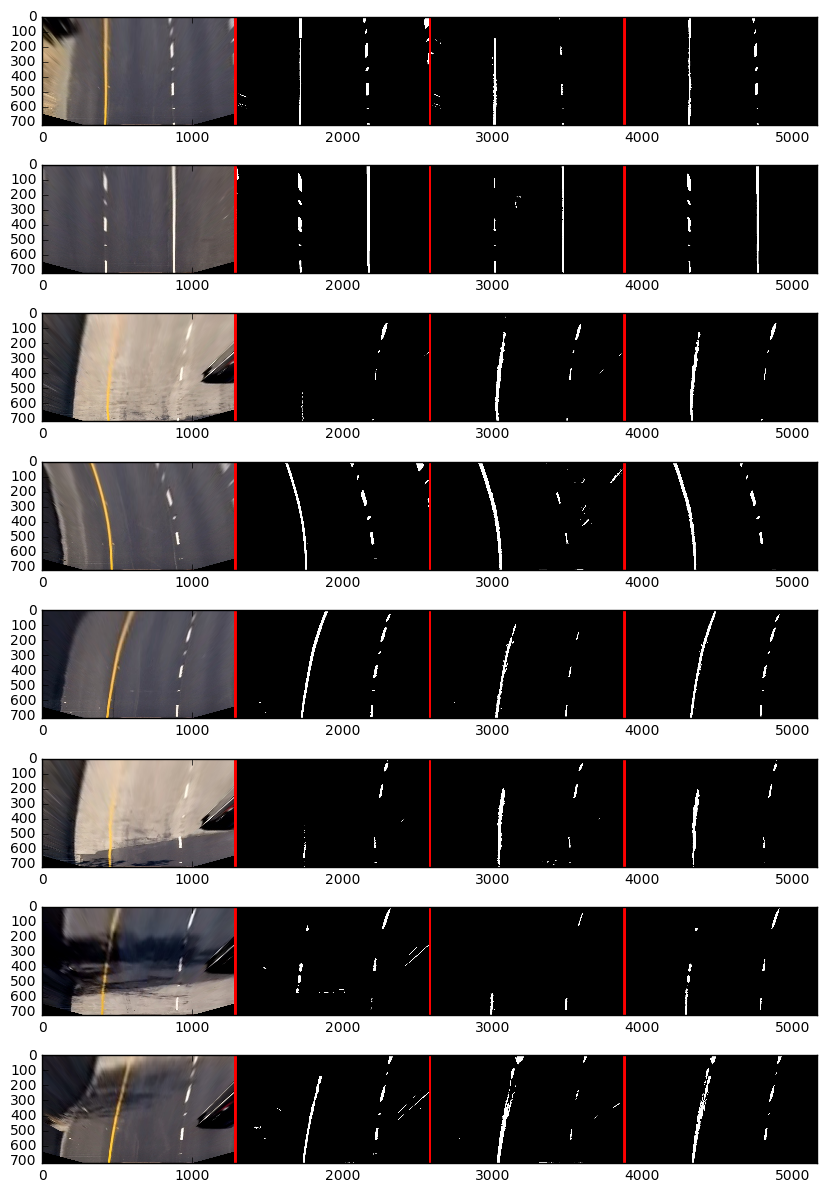

In [10]:
def test_search():
    def tu(img):
        return tilt_up(undistort(img))
    def reject(img,x):
        return remove_mask(img,cv2.inRange(hls(tu(x),1),0,40))
    def test_select(x):
        init_left, init_right = color_select(x)
        heat_map_left  = generate_inital_heat_map(init_left)
        heat_map_right = generate_inital_heat_map(init_right)
        left_line_color, right_line_color = color_select(x,heat_map_left,heat_map_right)
        return  left_line_color + right_line_color
    def red_line(x):
        dummy = np.zeros((x.shape[0], 15, 3), dtype=np.uint8)
        dummy[:,:,0] =255
        return dummy
    test_img(get_image_list("./test_images"), [
        lambda x: tu(x),
        lambda x: red_line(x),
        lambda x: fimg(reject(smart_th_select(hsv(tu(x),2),2.5, 5, 1),x)),
        lambda x: red_line(x),
        lambda x: fimg(reject(smart_th_select(hls(tu(x),2),2.5, 5, 1),x)),
        lambda x: red_line(x),
        lambda x: fimg(test_select(tu(x))),      
     ])
test_search()

## Run processing on test images 

[]

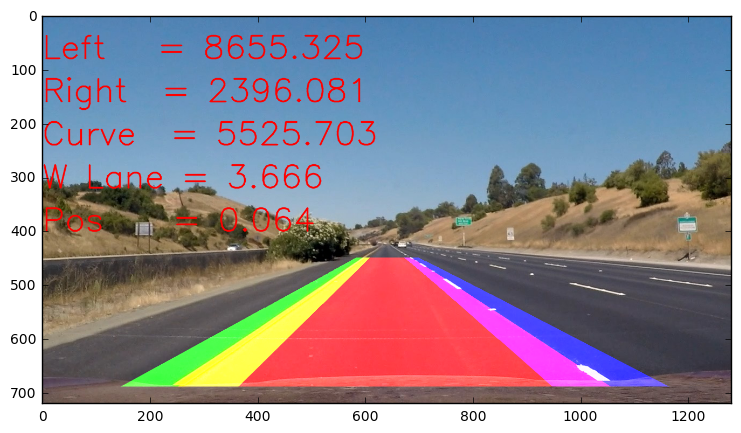

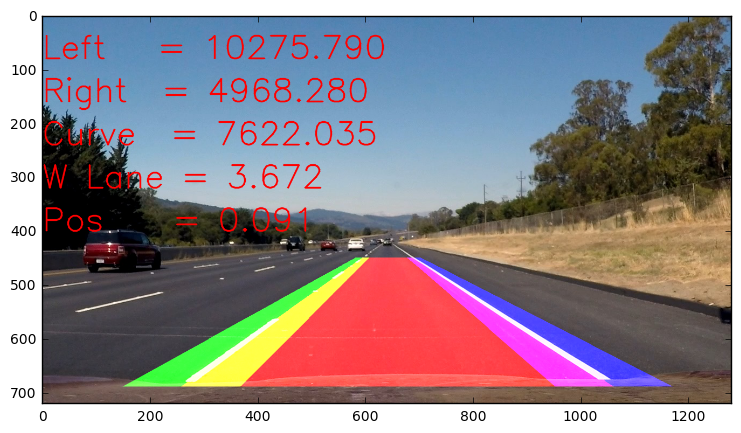

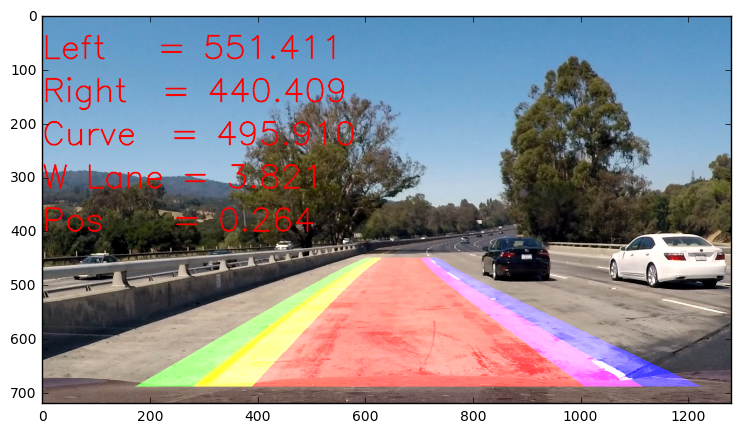

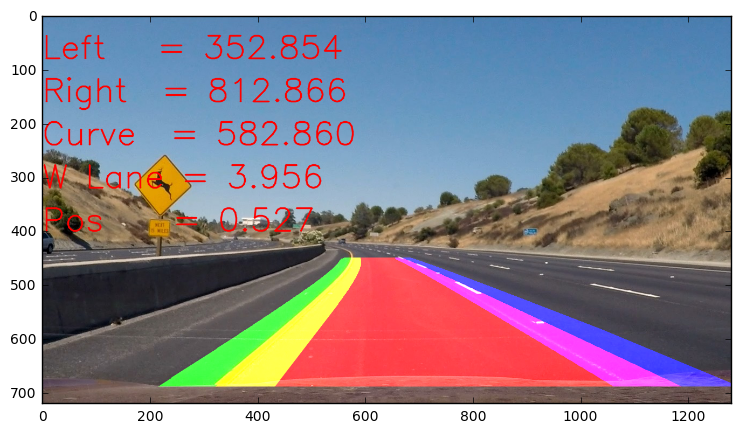

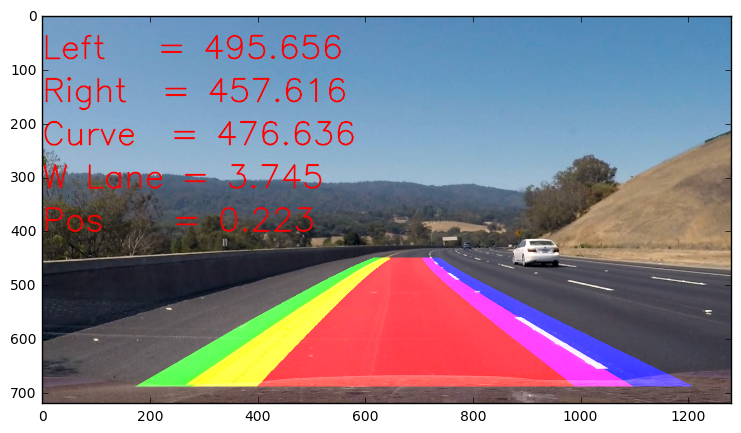

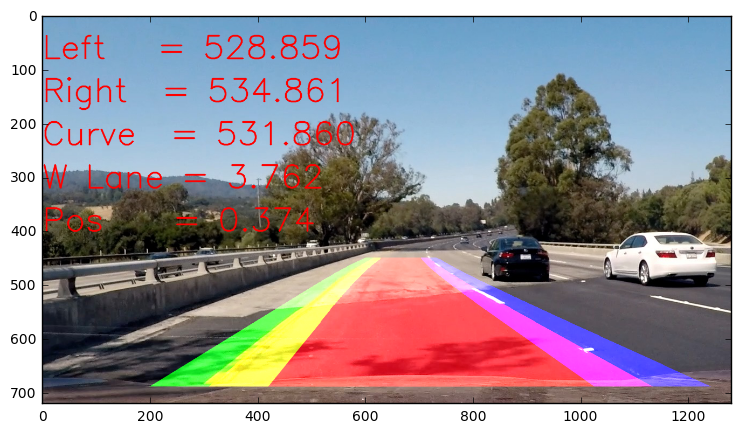

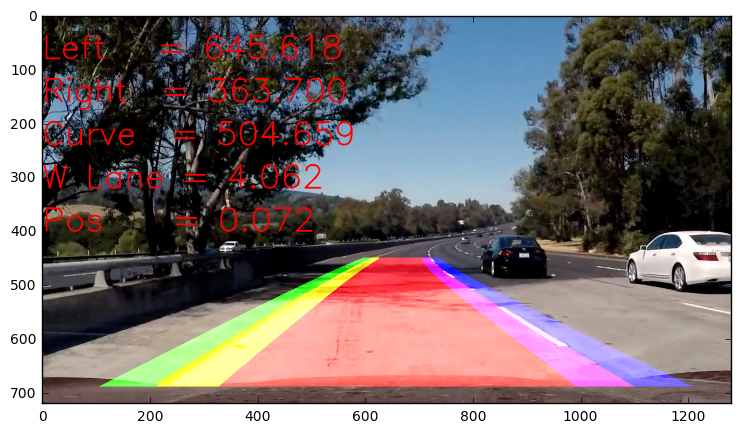

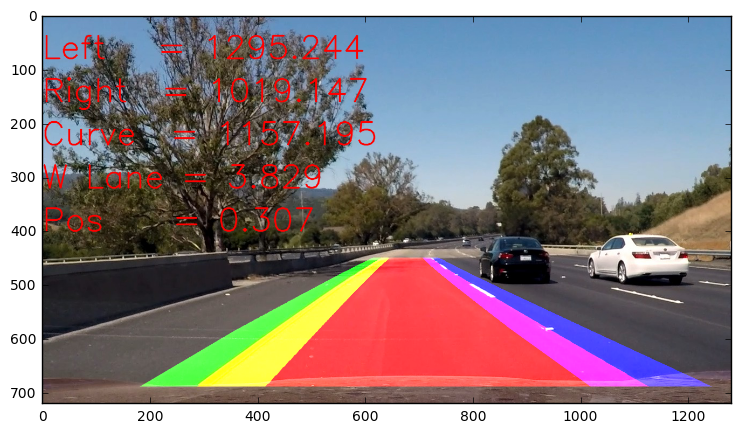

In [11]:
  
def pipeline_test(img):
    return Pipeline().process(img)

def output_images():
    # Test undistortion on an image
    dir_name = "./test_images"
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    for file_name in file_list:
        img = mpimg.imread(file_name)
        fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
        ax1.imshow(pipeline_test(img))
        fig.savefig("./output_images/"+ file_name.split('/')[-1], bbox_inches='tight')
    return image_list
    
output_images()

## Run processing on test videos

In [12]:
def test_vid(image, funcs):
    vis = []
    for func in funcs:
        vis.append(func(image))
    result = np.concatenate(vis, axis=1)
    return result
def process_video(input_file):
    output_file = "./output_videos/" + input_file.split('/')[-1]
    clip1 = VideoFileClip(input_file)
    pipeline = Pipeline()
    output_clip = clip1.fl_image(pipeline.process)
    output_clip.write_videofile(output_file, audio=False)

process_video("./test_videos/project_video.mp4")
process_video("./test_videos/challenge_video.mp4")
process_video("./test_videos/harder_challenge_video.mp4")

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|██████████| 485/485 [03:09<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [08:39<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video.mp4 

